In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml

import matplotlib.pyplot as plt

In [2]:
# import libraries to help evaluate our models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
data = pd.read_csv('merge.csv')

In [4]:
data.drop(['id patient', 'Jitter (ppq5)',
         'Jitter (ddp)','Shimmer (local dB)','Shimmer (apq3)','Shimmer (apq11)',
         'Shimmer (dda)','AC','NTH','Median pitch','Standard deviation',
         'Number of pulses','Number of periods','Mean period',
         'Standard deviation of period','Fraction of locally unvoiced frames','Number of voice breaks',
         'Degree of voice breaks','UPDRS',], inplace=True, axis=1)        
        
        
data.head()

,Jitter (local),Jitter (local absolute),Jitter (rap),Shimmer (local),Shimmer (apq5),HTN,Mean pitch,Minimum pitch,Maximum pitch,class information
0,1.488,0.000090,0.900,8.334,4.609,11.130,164.781,142.229,187.576,1
1,0.728,0.000038,0.353,5.864,3.180,17.403,193.289,159.515,234.505,1
2,1.220,0.000074,0.732,8.719,5.166,12.212,164.768,146.445,211.442,1
3,2.502,0.000123,1.156,13.513,8.771,11.384,203.471,182.713,220.230,1
4,3.509,0.000167,1.715,9.112,4.927,10.653,208.440,182.821,225.162,1


In [6]:
# ===================================================================================
#                       Data Preparation Function
# ===================================================================================


def data_prep(data_frame):
    
    shuffled = data.sample(frac=1)      # shuffle data
    features = shuffled.iloc[:, :-1]    # select only the features by dropping the last column
    labels = shuffled.iloc[:, -1]       # select only the labels by selecting the last column
    
    
    # split data into train and test, features and labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
        
    return X_train, y_train, X_test, y_test

def one_hot(labels):  
    
    depth = 2
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
X_train, Y_train, X_test, Y_test = data_prep(data)
y_train, y_test = one_hot(Y_train), one_hot(Y_test)


In [7]:
# Save the columns names as StandardScaler will strip them
X_cols = X_train.columns

# Initialize our Standard Scalar
ss = StandardScaler()

X_train = ss.fit_transform(X_train) # Fit scalar to training data and transform
X_test = ss.transform(X_test) # ONLY apply the transform to the test data

In [10]:
# convert them into tensorflow tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [11]:
# ===================================================================================
#                                Classical Layers
# ===================================================================================
# Define classical layers using Keras Sequential

keras.backend.set_floatx('float32')

hidden1 = layers.Dense(10, activation ="elu")
hidden2 = layers.Dense(10, activation ="elu")
out = layers.Dense(14, activation ="elu")     

In [12]:
# ===================================================================================
#                                Quantum State Encoding
# ===================================================================================

# quantum state preparation converting the classical output to quantum 
# init_layer(classical)|0> = |quantum>

def init_layer(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Beamsplitter(x[4], x[5], wires=[0,1])
    qml.Rotation(x[6], wires=0)
    qml.Rotation(x[7], wires=1)
    qml.Displacement(x[8], x[9], wires=0)
    qml.Displacement(x[10], x[11], wires=1)
    qml.Kerr(x[12], wires=0)
    qml.Kerr(x[13], wires=1)

In [13]:
# ===================================================================================
#                                    Quantum Layer
# ===================================================================================

# initialize parameters for the quantum layers: number of layers x number of parameters needed for all the gates

def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 2 + 1 + 1  # Number of interferometer parameters: beamsplitter + 2 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

# quantum layer for iteration

def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=1)
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Squeezing(v[5], 0.0, wires=1)
    qml.Beamsplitter(v[6], v[7], wires=[0,1])
    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    qml.Displacement(v[10], 0.0, wires=0)
    qml.Displacement(v[11], 0.0, wires=1)
    qml.Kerr(v[12], wires=0)
    qml.Kerr(v[13], wires=1)

In [14]:
# ===================================================================================
#                                    Quantum Circuit
# ===================================================================================

num_modes = 2
num_basis = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    init_layer(inputs)

    # iterative quantum layers
    for v in var:
        layer(v)
    
    return [qml.expval(qml.X(0)), qml.expval(qml.X(1))]

In [15]:
# ===================================================================================
#                                    Hybrid Model
# ===================================================================================

"""
Add the quantum layer to the classical to create a hybrid model
    1. initialize weights for quantum layers
    2. create a dictionary of weight shape to pass as one of the variables to covert to keras layer
    3. convert the quantum layer to a Keras layer
    4. add to the classical sequential model
"""
num_layers = 4

def hybrid_model(num_layers, num_modes):
    
    weigths = init_weights(num_layers, num_modes)
    shape_tup = weigths.shape
    weight_shapes = {'var': shape_tup}
    qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)
    hybrid_model = tf.keras.Sequential([hidden1, hidden2, out, qlayer])
    
    return hybrid_model

model = hybrid_model(num_layers, num_modes)

In [16]:
# ===================================================================================
#                                     Training
# ===================================================================================

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(opt, loss = 'MSE', metrics = ['accuracy'])

history = model.fit(X_train, 
                    y_train,
                    epochs = 5,
                    shuffle = True,
                    validation_data=(X_test, y_test))

Epoch 1/5
31/31 [==============================] - 900s 29s/step - loss: 0.4496 - accuracy: 0.4772 - val_loss: 0.2967 - val_accuracy: 0.4504
Epoch 2/5
31/31 [==============================] - 882s 28s/step - loss: 0.2478 - accuracy: 0.5807 - val_loss: 0.2300 - val_accuracy: 0.6405
Epoch 3/5
31/31 [==============================] - 891s 29s/step - loss: 0.2259 - accuracy: 0.6377 - val_loss: 0.2199 - val_accuracy: 0.6488
Epoch 4/5
31/31 [==============================] - 890s 29s/step - loss: 0.2170 - accuracy: 0.6718 - val_loss: 0.2132 - val_accuracy: 0.6694
Epoch 5/5
31/31 [==============================] - 894s 29s/step - loss: 0.2170 - accuracy: 0.6615 - val_loss: 0.2130 - val_accuracy: 0.6570


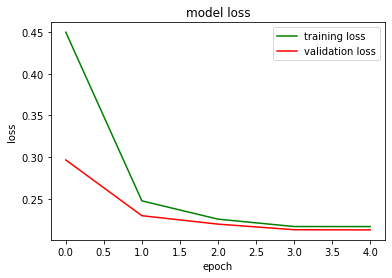

In [17]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(history.history['loss'], '-g', label = 'training loss')
plt.plot(history.history['val_loss'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

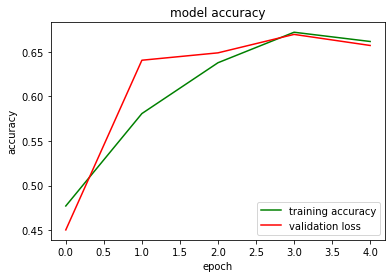

In [18]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(history.history['accuracy'], '-g', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()